visualization / EDA


In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os, random
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

PROJECT_DIR = Path("/content/drive/MyDrive/deeplearningproject/images")
PROJECT_DIR.mkdir(parents=True, exist_ok=True)

DATASET_DIR = Path("/content/drive/MyDrive/deeplearningproject/dataset")
TRAIN_DIR = DATASET_DIR / "training"
TEST_DIR  = DATASET_DIR / "testing"

CLASSES = ["glioma", "meningioma", "notumor", "pituitary"]

print("PROJECT_DIR:", PROJECT_DIR)
print("TRAIN_DIR exists:", TRAIN_DIR.exists(), TRAIN_DIR)
print("TEST_DIR exists :", TEST_DIR.exists(), TEST_DIR)

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)


Mounted at /content/drive
PROJECT_DIR: /content/drive/MyDrive/deeplearningproject/images
TRAIN_DIR exists: True /content/drive/MyDrive/deeplearningproject/dataset/training
TEST_DIR exists : True /content/drive/MyDrive/deeplearningproject/dataset/testing


In [2]:
def sample_image_paths(base_dir: Path, classes, n_per_class=3, seed=42):
    exts = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp"}
    rng = random.Random(seed)
    out = []
    for cls in classes:
        cls_dir = base_dir / cls
        paths = [p for p in cls_dir.rglob("*") if p.suffix.lower() in exts]
        rng.shuffle(paths)
        out.extend(paths[:n_per_class])
    return out

paths = sample_image_paths(TRAIN_DIR, CLASSES, n_per_class=5, seed=SEED)

sizes = []
modes = []
for p in paths:
    img = Image.open(p)
    sizes.append(img.size)
    modes.append(img.mode)

df_eda = pd.DataFrame({
    "path": [str(p) for p in paths],
    "width": [s[0] for s in sizes],
    "height": [s[1] for s in sizes],
    "mode": modes
})

df_eda.head()


,path,width,height,mode
0,/content/drive/MyDrive/deeplearningproject/dat...,512,512,L
1,/content/drive/MyDrive/deeplearningproject/dat...,512,512,L
2,/content/drive/MyDrive/deeplearningproject/dat...,512,512,L
3,/content/drive/MyDrive/deeplearningproject/dat...,512,512,L
4,/content/drive/MyDrive/deeplearningproject/dat...,512,512,L


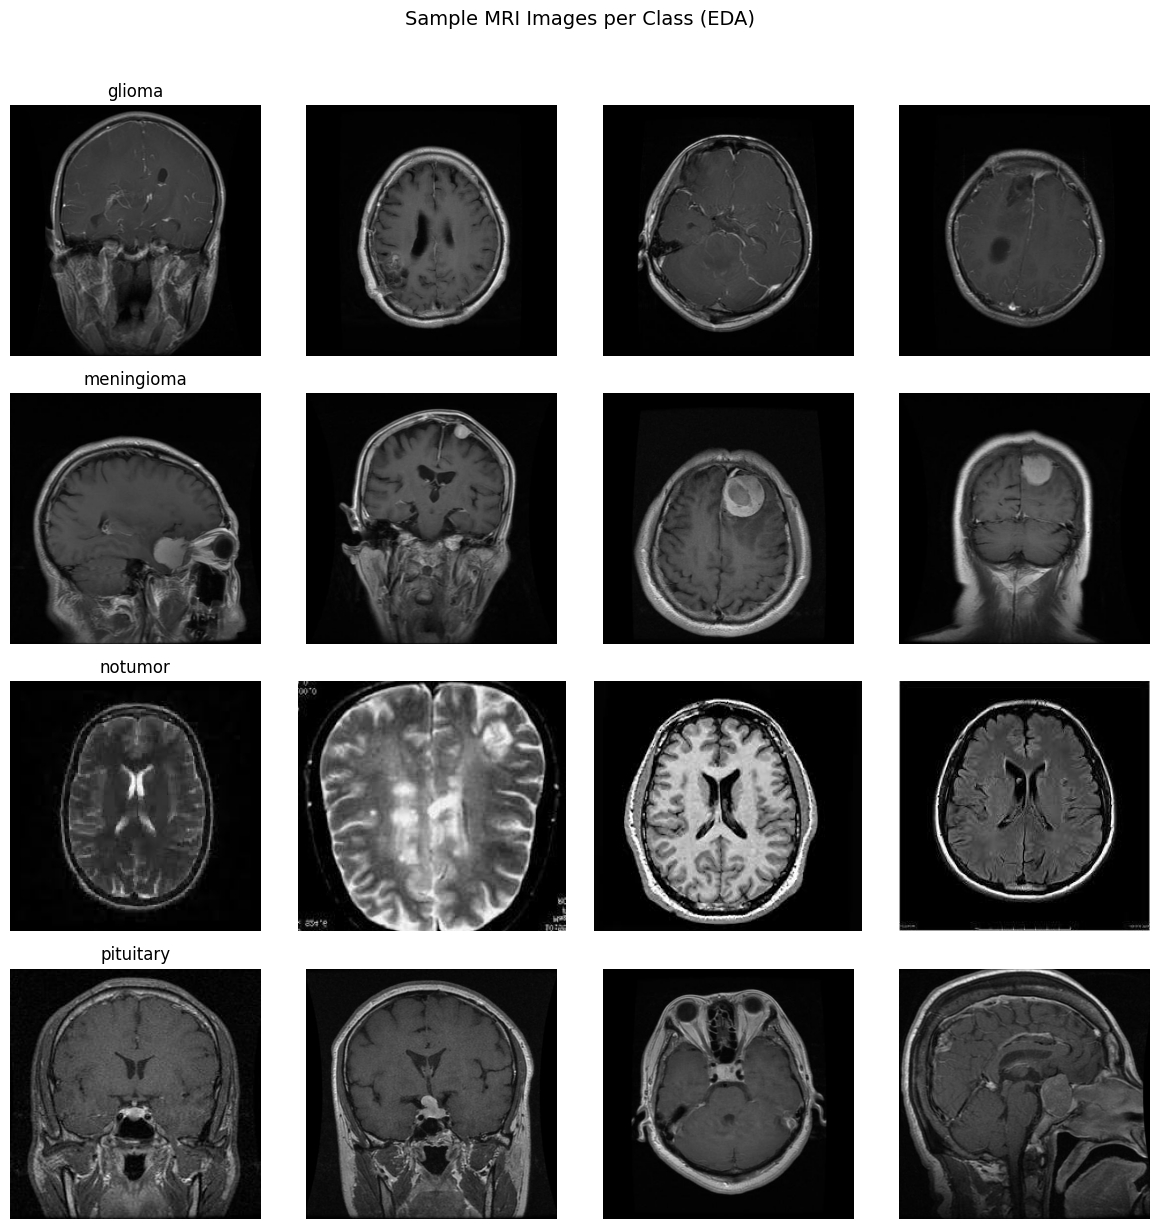

Saved: /content/drive/MyDrive/deeplearningproject/images/figure_4_1_eda_samples_grid.png


In [3]:
def plot_class_grid(base_dir: Path, classes, k=4, seed=42):
    exts = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp"}
    rng = random.Random(seed)

    samples = {}
    for cls in classes:
        cls_dir = base_dir / cls
        paths = [p for p in cls_dir.rglob("*") if p.suffix.lower() in exts]
        rng.shuffle(paths)
        samples[cls] = paths[:k]

    nrows = len(classes)
    ncols = k
    plt.figure(figsize=(3*ncols, 3*nrows))
    idx = 1

    for r, cls in enumerate(classes):
        for c in range(k):
            plt.subplot(nrows, ncols, idx)
            idx += 1
            if c >= len(samples[cls]):
                plt.axis("off")
                continue
            img = Image.open(samples[cls][c]).convert("RGB")
            plt.imshow(img)
            plt.axis("off")
            if c == 0:
                plt.title(cls)

    plt.suptitle("Sample MRI Images per Class (EDA)", y=1.02, fontsize=14)
    plt.tight_layout()


    outpath = PROJECT_DIR / "figure_4_1_eda_samples_grid.png"
    plt.savefig(outpath, dpi=300, bbox_inches="tight")
    plt.show()

    print("Saved:", outpath)

plot_class_grid(TRAIN_DIR, CLASSES, k=4, seed=SEED)


Train/Validation

In [4]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
VAL_SPLIT = 0.15

train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    labels="inferred",
    label_mode="int",
    class_names=CLASSES,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=VAL_SPLIT,
    subset="training"
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    labels="inferred",
    label_mode="int",
    class_names=CLASSES,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=VAL_SPLIT,
    subset="validation"
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    labels="inferred",
    label_mode="int",
    class_names=CLASSES,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print("Class names:", train_ds.class_names)


Found 5712 files belonging to 4 classes.
Using 4856 files for training.
Found 5712 files belonging to 4 classes.
Using 856 files for validation.
Found 1311 files belonging to 4 classes.
Class names: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [5]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds  = test_ds.prefetch(buffer_size=AUTOTUNE)


Preprocessing pipeline

In [6]:
 normalization = layers.Rescaling(1./255)

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.10),
], name="data_augmentation")

print("Preprocessing pipeline ready.")


Preprocessing pipeline ready.


In [7]:
from collections import Counter

y = []
for _, labels in train_ds.unbatch():
    y.append(int(labels.numpy()))
counts = Counter(y)

total = sum(counts.values())
num_classes = len(CLASSES)

class_weight = {}
for cls_idx in range(num_classes):
    class_weight[cls_idx] = total / (num_classes * counts.get(cls_idx, 1))

class_weight


{0: 1.063047285464098,
 1: 1.0519930675909879,
 2: 0.9086826347305389,
 3: 0.9918300653594772}

In [ ]:
pd.DataFrame({
    "class_index": list(class_weight.keys()),
    "class_name": [CLASSES[i] for i in class_weight.keys()],
    "class_weight": list(class_weight.values())
}).to_csv(PROJECT_DIR / "class_weights.csv", index=False)


CNN

In [8]:
NUM_CLASSES = len(CLASSES)

def build_baseline_cnn(input_shape=(224,224,3), num_classes=4):
    model = keras.Sequential([
        layers.Input(shape=input_shape),

        layers.Conv2D(32, (3,3), activation="relu", padding="same"),
        layers.MaxPooling2D(),

        layers.Conv2D(64, (3,3), activation="relu", padding="same"),
        layers.MaxPooling2D(),

        layers.Conv2D(128, (3,3), activation="relu", padding="same"),
        layers.MaxPooling2D(),

        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax")
    ])
    return model

baseline_model = build_baseline_cnn(
    input_shape=IMG_SIZE + (3,),
    num_classes=NUM_CLASSES
)

baseline_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,938,948 (49.36 MB)

 Trainable params: 12,938,948 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
baseline_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


In [10]:
EPOCHS = 15

history_baseline = baseline_model.fit(
    train_ds.map(lambda x, y: (normalization(x), y)),
    validation_data=val_ds.map(lambda x, y: (normalization(x), y)),
    epochs=EPOCHS,
    class_weight=class_weight
)


Epoch 1/15
152/152 ━━━━━━━━━━━━━━━━━━━━ 66s 384ms/step - accuracy: 0.5308 - loss: 1.0488 - val_accuracy: 0.8189 - val_loss: 0.5499
Epoch 2/15
152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7940 - loss: 0.5695 - val_accuracy: 0.8329 - val_loss: 0.4382
Epoch 3/15
152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8506 - loss: 0.4274 - val_accuracy: 0.8762 - val_loss: 0.3372
Epoch 4/15
152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8787 - loss: 0.3433 - val_accuracy: 0.8949 - val_loss: 0.3042
Epoch 5/15
152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8949 - loss: 0.2982 - val_accuracy: 0.8937 - val_loss: 0.2868
Epoch 6/15
152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9179 - loss: 0.2368 - val_accuracy: 0.9089 - val_loss: 0.2595
Epoch 7/15
152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9216 - loss: 0.2150 - val_accuracy: 0.9229 - val_loss: 0.2577
Epoch 8/15
152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9378 - loss: 0.1823 - val_ac

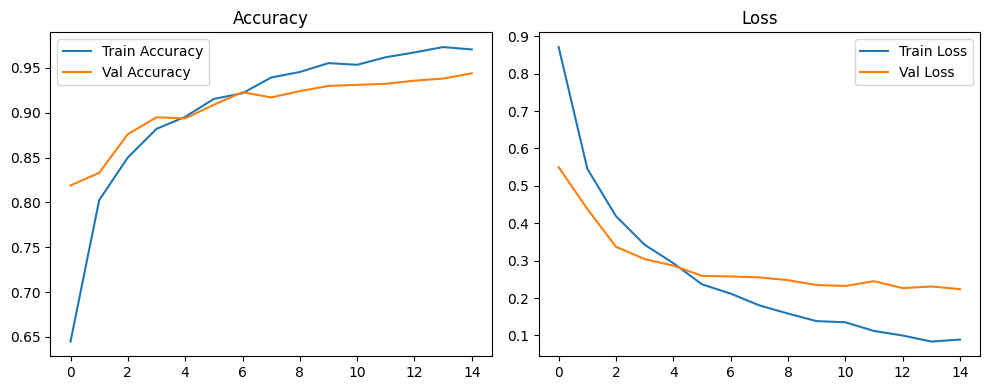

Saved: /content/drive/MyDrive/deeplearningproject/images/figure_4_2_baseline_cnn_training_curves.png


In [11]:
def plot_training_history(history, model_name):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs_range = range(len(acc))

    plt.figure(figsize=(10,4))

    plt.subplot(1,2,1)
    plt.plot(epochs_range, acc, label="Train Accuracy")
    plt.plot(epochs_range, val_acc, label="Val Accuracy")
    plt.legend()
    plt.title("Accuracy")

    plt.subplot(1,2,2)
    plt.plot(epochs_range, loss, label="Train Loss")
    plt.plot(epochs_range, val_loss, label="Val Loss")
    plt.legend()
    plt.title("Loss")

    plt.tight_layout()

    outpath = PROJECT_DIR / f"figure_4_2_{model_name}_training_curves.png"
    plt.savefig(outpath, dpi=300, bbox_inches="tight")
    plt.show()

    print("Saved:", outpath)

plot_training_history(history_baseline, "baseline_cnn")


In [12]:
test_loss, test_acc = baseline_model.evaluate(
    test_ds.map(lambda x, y: (normalization(x), y))
)

print("Baseline CNN Test Accuracy:", test_acc)


41/41 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.9069 - loss: 0.3340
Baseline CNN Test Accuracy: 0.9405034184455872


In [13]:
with open(PROJECT_DIR / "baseline_test_results.txt", "w") as f:
    f.write(f"Test Accuracy: {test_acc:.4f}\n")


ResNet50

In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

IMG_SIZE = (224, 224)
NUM_CLASSES = len(CLASSES)

EPOCHS_FROZEN = 8
EPOCHS_FINETUNE = 7
LR_FROZEN = 1e-4
LR_FINETUNE = 1e-5

ckpt_path = PROJECT_DIR / "resnet50_best.keras"

callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint(filepath=str(ckpt_path), monitor="val_loss", save_best_only=True)
]


In [15]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess


def prepare_for_resnet(ds, training=False):
    def _map(x, y):
        x = tf.cast(x, tf.float32)
        if training:
            x = data_augmentation(x)
        x = resnet_preprocess(x)
        return x, y
    return ds.map(_map, num_parallel_calls=tf.data.AUTOTUNE)


base_model = ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=IMG_SIZE + (3,)
)

base_model.trainable = False

inputs = keras.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = resnet_preprocess(x)

x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

resnet_model = keras.Model(inputs, outputs, name="ResNet50_transfer")

resnet_model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "ResNet50_transfer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 224, 224,  │          0 │ input_layer_2[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ data_augmentatio… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ data_augmentatio… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ data_augmentatio… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add[0][0]         │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 2048)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 4)         │      8,196 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,595,908 (90.01 MB)

 Trainable params: 8,196 (32.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [16]:
resnet_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LR_FROZEN),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history_resnet_frozen = resnet_model.fit(
    prepare_for_resnet(train_ds, training=True),
    validation_data=prepare_for_resnet(val_ds, training=False),
    epochs=EPOCHS_FROZEN,
    class_weight=class_weight,
    callbacks=callbacks
)


Epoch 1/8
152/152 ━━━━━━━━━━━━━━━━━━━━ 22s 78ms/step - accuracy: 0.3404 - loss: 1.5283 - val_accuracy: 0.6273 - val_loss: 0.9195
Epoch 2/8
152/152 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.6133 - loss: 0.9522 - val_accuracy: 0.7185 - val_loss: 0.7415
Epoch 3/8
152/152 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.7168 - loss: 0.7444 - val_accuracy: 0.7593 - val_loss: 0.6513
Epoch 4/8
152/152 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.7551 - loss: 0.6576 - val_accuracy: 0.7827 - val_loss: 0.5921
Epoch 5/8
152/152 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.7745 - loss: 0.6093 - val_accuracy: 0.7967 - val_loss: 0.5530
Epoch 6/8
152/152 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.7922 - loss: 0.5575 - val_accuracy: 0.8061 - val_loss: 0.5241
Epoch 7/8
152/152 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.8019 - loss: 0.5304 - val_accuracy: 0.8143 - val_loss: 0.5043
Epoch 8/8
152/152 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.8202 - loss: 0.5031 - val_accuracy

In [17]:

base_model.trainable = True


N = 40
for layer in base_model.layers[:-N]:
    layer.trainable = False

for layer in base_model.layers:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False

resnet_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LR_FINETUNE),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history_resnet_finetune = resnet_model.fit(
    prepare_for_resnet(train_ds, training=True),
    validation_data=prepare_for_resnet(val_ds, training=False),
    epochs=EPOCHS_FINETUNE,
    class_weight=class_weight,
    callbacks=callbacks
)


Epoch 1/7
152/152 ━━━━━━━━━━━━━━━━━━━━ 24s 88ms/step - accuracy: 0.8440 - loss: 0.4268 - val_accuracy: 0.8960 - val_loss: 0.2841
Epoch 2/7
152/152 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 0.9034 - loss: 0.2796 - val_accuracy: 0.9065 - val_loss: 0.2550
Epoch 3/7
152/152 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.9237 - loss: 0.2130 - val_accuracy: 0.8995 - val_loss: 0.2896
Epoch 4/7
152/152 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - accuracy: 0.9371 - loss: 0.1733 - val_accuracy: 0.9136 - val_loss: 0.2334
Epoch 5/7
152/152 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.9577 - loss: 0.1248 - val_accuracy: 0.9217 - val_loss: 0.2333
Epoch 6/7
152/152 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 0.9539 - loss: 0.1211 - val_accuracy: 0.9241 - val_loss: 0.2291
Epoch 7/7
152/152 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.9647 - loss: 0.0996 - val_accuracy: 0.9229 - val_loss: 0.2669


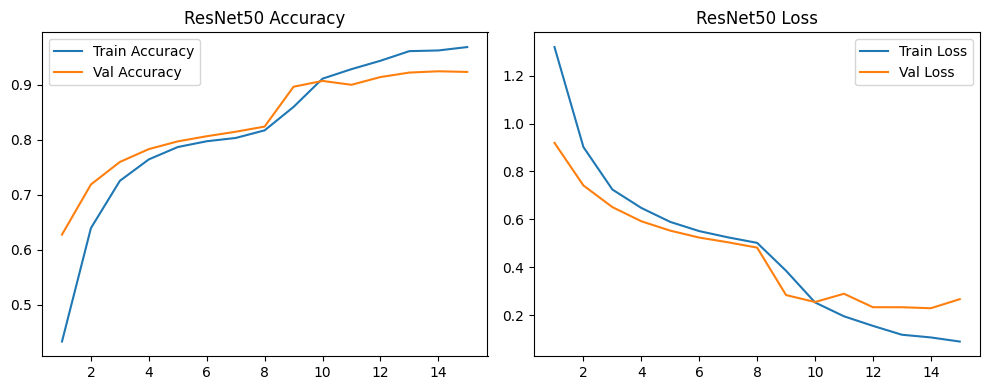

Saved: /content/drive/MyDrive/deeplearningproject/images/figure_4_3_resnet50_training_curves.png


In [18]:
def merge_histories(h1, h2):
    out = {}
    for k in h1.history.keys():
        out[k] = h1.history[k] + h2.history.get(k, [])
    return out

merged = merge_histories(history_resnet_frozen, history_resnet_finetune)

epochs_range = range(1, len(merged["accuracy"]) + 1)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(epochs_range, merged["accuracy"], label="Train Accuracy")
plt.plot(epochs_range, merged["val_accuracy"], label="Val Accuracy")
plt.title("ResNet50 Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range, merged["loss"], label="Train Loss")
plt.plot(epochs_range, merged["val_loss"], label="Val Loss")
plt.title("ResNet50 Loss")
plt.legend()

plt.tight_layout()

outpath = PROJECT_DIR / "figure_4_3_resnet50_training_curves.png"
plt.savefig(outpath, dpi=300, bbox_inches="tight")
plt.show()

print("Saved:", outpath)


In [21]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix


y_true = []
y_pred = []

for x_batch, y_batch in test_ds:
    x_batch = resnet_preprocess(tf.cast(x_batch, tf.float32))
    preds = resnet_model.predict(x_batch, verbose=0)
    y_true.extend(y_batch.numpy().tolist())
    y_pred.extend(np.argmax(preds, axis=1).tolist())

report = classification_report(y_true, y_pred, target_names=CLASSES, digits=4)
cm = confusion_matrix(y_true, y_pred)

print(report)
print("Confusion Matrix:\n", cm)


with open(PROJECT_DIR / "resnet50_classification_report.txt", "w") as f:
    f.write(report)

np.savetxt(PROJECT_DIR / "resnet50_confusion_matrix.csv", cm, delimiter=",", fmt="%d")


              precision    recall  f1-score   support

      glioma     0.9885    0.8633    0.9217       300
  meningioma     0.9120    0.8464    0.8780       306
     notumor     0.9222    0.9951    0.9572       405
   pituitary     0.9085    0.9933    0.9490       300

    accuracy                         0.9298      1311
   macro avg     0.9328    0.9245    0.9265      1311
weighted avg     0.9319    0.9298    0.9287      1311

Confusion Matrix:
 [[259  22  12   7]
 [  3 259  21  23]
 [  0   2 403   0]
 [  0   1   1 298]]


EfficientNet-B0

In [26]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input as eff_preprocess

IMG_SIZE = (224, 224)
NUM_CLASSES = len(CLASSES)

EPOCHS_FROZEN = 8
EPOCHS_FINETUNE = 7
LR_FROZEN = 1e-4
LR_FINETUNE = 1e-5


In [27]:
 base_model_eff = EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=IMG_SIZE + (3,)
)

base_model_eff.trainable = False

inputs = keras.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = eff_preprocess(x)

x = base_model_eff(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

effnet_model = keras.Model(inputs, outputs, name="EfficientNetB0_transfer")

effnet_model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "EfficientNetB0_transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,059,815 (15.49 MB)

 Trainable params: 7,684 (30.02 KB)

 Non-trainable params: 4,052,131 (15.46 MB)

In [28]:
effnet_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LR_FROZEN),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history_eff_frozen = effnet_model.fit(
    train_ds.map(lambda x, y: (eff_preprocess(tf.cast(x, tf.float32)), y)),
    validation_data=val_ds.map(lambda x, y: (eff_preprocess(tf.cast(x, tf.float32)), y)),
    epochs=EPOCHS_FROZEN,
    class_weight=class_weight,
    callbacks=callbacks
)


Epoch 1/8
152/152 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.3389 - loss: 1.8987 - val_accuracy: 0.6145 - val_loss: 0.9358
Epoch 2/8
152/152 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.6537 - loss: 0.9413 - val_accuracy: 0.7126 - val_loss: 0.7106
Epoch 3/8
152/152 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.7215 - loss: 0.7493 - val_accuracy: 0.7453 - val_loss: 0.6459
Epoch 4/8
152/152 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.7527 - loss: 0.6625 - val_accuracy: 0.7687 - val_loss: 0.6085
Epoch 5/8
152/152 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.7902 - loss: 0.5952 - val_accuracy: 0.7792 - val_loss: 0.5804
Epoch 6/8
152/152 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.7990 - loss: 0.5704 - val_accuracy: 0.7850 - val_loss: 0.5561
Epoch 7/8
152/152 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.8076 - loss: 0.5353 - val_accuracy: 0.7979 - val_loss: 0.5417
Epoch 8/8
152/152 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.8230 - loss: 0.4969 - val_accuracy: 0

In [29]:
base_model_eff.trainable = True

N = 40
for layer in base_model_eff.layers[:-N]:
    layer.trainable = False

# BatchNorm'ları dondur
for layer in base_model_eff.layers:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False

effnet_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LR_FINETUNE),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history_eff_finetune = effnet_model.fit(
    train_ds.map(lambda x, y: (eff_preprocess(tf.cast(x, tf.float32)), y)),
    validation_data=val_ds.map(lambda x, y: (eff_preprocess(tf.cast(x, tf.float32)), y)),
    epochs=EPOCHS_FINETUNE,
    class_weight=class_weight,
    callbacks=callbacks
)


Epoch 1/7
152/152 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.8278 - loss: 0.4667 - val_accuracy: 0.8166 - val_loss: 0.5019
Epoch 2/7
152/152 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.8445 - loss: 0.4569 - val_accuracy: 0.8259 - val_loss: 0.4820
Epoch 3/7
152/152 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.8481 - loss: 0.4029 - val_accuracy: 0.8318 - val_loss: 0.4573
Epoch 4/7
152/152 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.8619 - loss: 0.3794 - val_accuracy: 0.8516 - val_loss: 0.4284
Epoch 5/7
152/152 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.8601 - loss: 0.3655 - val_accuracy: 0.8528 - val_loss: 0.4149
Epoch 6/7
152/152 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.8709 - loss: 0.3537 - val_accuracy: 0.8598 - val_loss: 0.3863
Epoch 7/7
152/152 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.8881 - loss: 0.3125 - val_accuracy: 0.8621 - val_loss: 0.3872


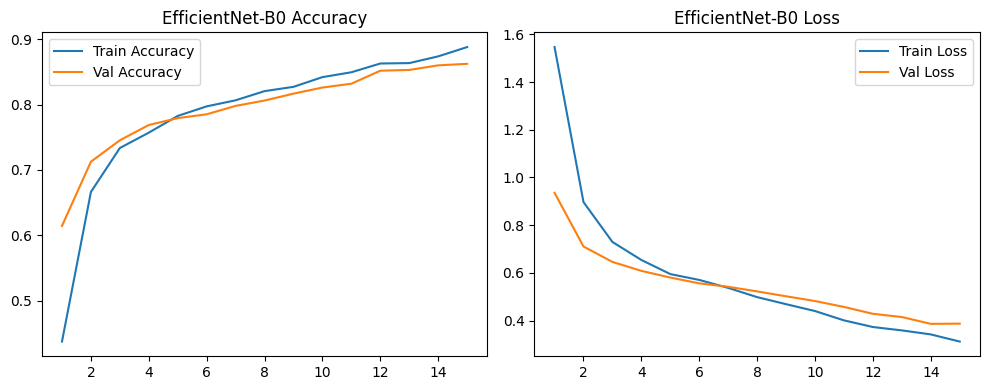

Saved: /content/drive/MyDrive/deeplearningproject/images/figure_4_5_efficientnetb0_training_curves.png


In [30]:
def merge_histories(h1, h2):
    out = {}
    for k in h1.history.keys():
        out[k] = h1.history[k] + h2.history.get(k, [])
    return out

merged_eff = merge_histories(history_eff_frozen, history_eff_finetune)

epochs_range = range(1, len(merged_eff["accuracy"]) + 1)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(epochs_range, merged_eff["accuracy"], label="Train Accuracy")
plt.plot(epochs_range, merged_eff["val_accuracy"], label="Val Accuracy")
plt.title("EfficientNet-B0 Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range, merged_eff["loss"], label="Train Loss")
plt.plot(epochs_range, merged_eff["val_loss"], label="Val Loss")
plt.title("EfficientNet-B0 Loss")
plt.legend()

plt.tight_layout()

outpath = PROJECT_DIR / "figure_4_5_efficientnetb0_training_curves.png"
plt.savefig(outpath, dpi=300, bbox_inches="tight")
plt.show()

print("Saved:", outpath)


In [32]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_true = []
y_pred = []

for x_batch, y_batch in test_ds:
    x_batch = eff_preprocess(tf.cast(x_batch, tf.float32))
    preds = effnet_model.predict(x_batch, verbose=0)
    y_true.extend(y_batch.numpy().tolist())
    y_pred.extend(np.argmax(preds, axis=1).tolist())

report_eff = classification_report(y_true, y_pred, target_names=CLASSES, digits=4)
cm_eff = confusion_matrix(y_true, y_pred)

print(report_eff)
print("Confusion Matrix:\n", cm_eff)

with open(PROJECT_DIR / "efficientnetb0_classification_report.txt", "w") as f:
    f.write(report_eff)

np.savetxt(PROJECT_DIR / "efficientnetb0_confusion_matrix.csv", cm_eff, delimiter=",", fmt="%d")


              precision    recall  f1-score   support

      glioma     0.8638    0.8033    0.8325       300
  meningioma     0.8089    0.6503    0.7210       306
     notumor     0.9481    0.9481    0.9481       405
   pituitary     0.7822    0.9933    0.8752       300

    accuracy                         0.8558      1311
   macro avg     0.8508    0.8488    0.8442      1311
weighted avg     0.8584    0.8558    0.8520      1311

Confusion Matrix:
 [[241  42   1  16]
 [ 27 199  20  60]
 [  9   5 384   7]
 [  2   0   0 298]]


MobileNetV2

In [37]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mob_preprocess
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

IMG_SIZE = (224, 224)
NUM_CLASSES = len(CLASSES)

EPOCHS_FROZEN = 8
EPOCHS_FINETUNE = 7
LR_FROZEN = 1e-4
LR_FINETUNE = 1e-5


In [38]:
 base_model_mob = MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=IMG_SIZE + (3,)
)

base_model_mob.trainable = False

inputs = keras.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = mob_preprocess(x)

x = base_model_mob(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

mobilenet_model = keras.Model(inputs, outputs, name="MobileNetV2_transfer")

mobilenet_model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "MobileNetV2_transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [39]:
mobilenet_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LR_FROZEN),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history_mob_frozen = mobilenet_model.fit(
    train_ds.map(lambda x, y: (mob_preprocess(tf.cast(x, tf.float32)), y)),
    validation_data=val_ds.map(lambda x, y: (mob_preprocess(tf.cast(x, tf.float32)), y)),
    epochs=EPOCHS_FROZEN,
    class_weight=class_weight,
    callbacks=callbacks
)


Epoch 1/8
152/152 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.3256 - loss: 1.4867 - val_accuracy: 0.4755 - val_loss: 1.1455
Epoch 2/8
152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.3745 - loss: 1.3058 - val_accuracy: 0.5245 - val_loss: 1.1040
Epoch 3/8
152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.4275 - loss: 1.2435 - val_accuracy: 0.5654 - val_loss: 1.0733
Epoch 4/8
152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.4373 - loss: 1.2119 - val_accuracy: 0.5806 - val_loss: 1.0533
Epoch 5/8
152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.4597 - loss: 1.2059 - val_accuracy: 0.5794 - val_loss: 1.0347
Epoch 6/8
152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.4699 - loss: 1.1813 - val_accuracy: 0.5864 - val_loss: 1.0222
Epoch 7/8
152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.4871 - loss: 1.1505 - val_accuracy: 0.5981 - val_loss: 1.0087
Epoch 8/8
152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.5101 - loss: 1.1352 - val_accuracy: 0

In [40]:
base_model_mob.trainable = True

N = 50
for layer in base_model_mob.layers[:-N]:
    layer.trainable = False

for layer in base_model_mob.layers:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False

mobilenet_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LR_FINETUNE),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history_mob_finetune = mobilenet_model.fit(
    train_ds.map(lambda x, y: (mob_preprocess(tf.cast(x, tf.float32)), y)),
    validation_data=val_ds.map(lambda x, y: (mob_preprocess(tf.cast(x, tf.float32)), y)),
    epochs=EPOCHS_FINETUNE,
    class_weight=class_weight,
    callbacks=callbacks
)


Epoch 1/7
152/152 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.5340 - loss: 1.0968 - val_accuracy: 0.6425 - val_loss: 0.8627
Epoch 2/7
152/152 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.5883 - loss: 0.9691 - val_accuracy: 0.6799 - val_loss: 0.7727
Epoch 3/7
152/152 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.6256 - loss: 0.8809 - val_accuracy: 0.6495 - val_loss: 0.8168
Epoch 4/7
152/152 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.6477 - loss: 0.8428 - val_accuracy: 0.6308 - val_loss: 0.8432
Epoch 5/7
152/152 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.6654 - loss: 0.8012 - val_accuracy: 0.6542 - val_loss: 0.7610
Epoch 6/7
152/152 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.6902 - loss: 0.7590 - val_accuracy: 0.6484 - val_loss: 0.7614
Epoch 7/7
152/152 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.6979 - loss: 0.7535 - val_accuracy: 0.6939 - val_loss: 0.6947


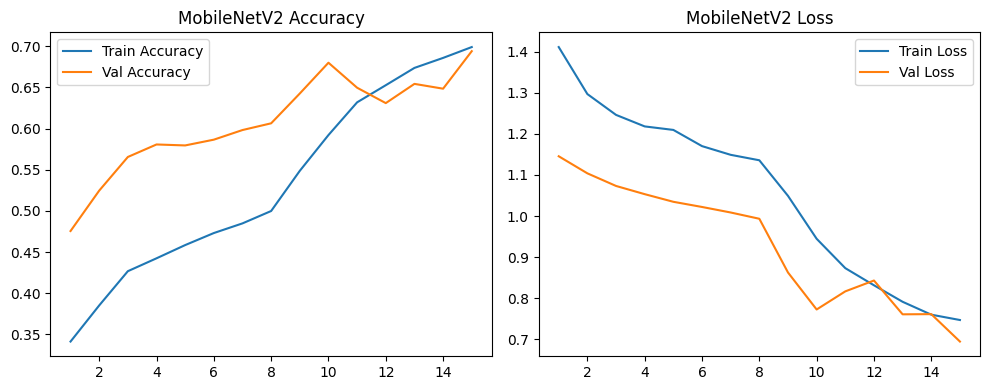

Saved: /content/drive/MyDrive/deeplearningproject/images/figure_4_7_mobilenetv2_training_curves.png


In [41]:
import matplotlib.pyplot as plt

def merge_histories(h1, h2):
    out = {}
    for k in h1.history.keys():
        out[k] = h1.history[k] + h2.history.get(k, [])
    return out

merged_mob = merge_histories(history_mob_frozen, history_mob_finetune)
epochs_range = range(1, len(merged_mob["accuracy"]) + 1)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(epochs_range, merged_mob["accuracy"], label="Train Accuracy")
plt.plot(epochs_range, merged_mob["val_accuracy"], label="Val Accuracy")
plt.title("MobileNetV2 Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range, merged_mob["loss"], label="Train Loss")
plt.plot(epochs_range, merged_mob["val_loss"], label="Val Loss")
plt.title("MobileNetV2 Loss")
plt.legend()

plt.tight_layout()

outpath = PROJECT_DIR / "figure_4_7_mobilenetv2_training_curves.png"
plt.savefig(outpath, dpi=300, bbox_inches="tight")
plt.show()

print("Saved:", outpath)


In [42]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

y_true = []
y_pred = []

for x_batch, y_batch in test_ds:
    x_batch = mob_preprocess(tf.cast(x_batch, tf.float32))
    preds = mobilenet_model.predict(x_batch, verbose=0)
    y_true.extend(y_batch.numpy().tolist())
    y_pred.extend(np.argmax(preds, axis=1).tolist())

report_mob = classification_report(y_true, y_pred, target_names=CLASSES, digits=4)
print(report_mob)

with open(PROJECT_DIR / "mobilenetv2_classification_report.txt", "w") as f:
    f.write(report_mob)

cm_mob = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm_mob)

np.savetxt(PROJECT_DIR / "mobilenetv2_confusion_matrix.csv", cm_mob, delimiter=",", fmt="%d")

report_dict = classification_report(y_true, y_pred, target_names=CLASSES, output_dict=True, digits=4)
df_report = pd.DataFrame(report_dict).transpose()
df_class_metrics = df_report.loc[CLASSES, ["precision", "recall", "f1-score", "support"]]

df_class_metrics.to_csv(PROJECT_DIR / "table_4_4_mobilenetv2_class_metrics.csv")
df_class_metrics.to_excel(PROJECT_DIR / "table_4_4_mobilenetv2_class_metrics.xlsx")

df_class_metrics


              precision    recall  f1-score   support

      glioma     0.7591    0.3467    0.4760       300
  meningioma     0.4385    0.5131    0.4729       306
     notumor     0.6254    0.9358    0.7498       405
   pituitary     0.7952    0.5567    0.6549       300

    accuracy                         0.6156      1311
   macro avg     0.6546    0.5881    0.5884      1311
weighted avg     0.6513    0.6156    0.6008      1311

Confusion Matrix:
 [[104 159  19  18]
 [ 10 157 117  22]
 [ 11  12 379   3]
 [ 12  30  91 167]]


,precision,recall,f1-score,support
glioma,0.759124,0.346667,0.475973,300.0
meningioma,0.438547,0.513072,0.472892,306.0
notumor,0.625413,0.935802,0.749753,405.0
pituitary,0.795238,0.556667,0.654902,300.0


Best Model

In [44]:
final_model_path = PROJECT_DIR / "final_baseline_cnn_model.keras"
baseline_model.save(final_model_path)

print("Final model saved to:", final_model_path)


Final model saved to: /content/drive/MyDrive/deeplearningproject/images/final_baseline_cnn_model.keras


In [45]:
import tensorflow as tf

loaded_model = tf.keras.models.load_model(final_model_path)
loaded_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,816,846 (148.07 MB)

 Trainable params: 12,938,948 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 25,877,898 (98.72 MB)

In [46]:
import numpy as np


for x_batch, y_batch in test_ds.take(1):
    x_batch = normalization(tf.cast(x_batch, tf.float32))
    preds = loaded_model.predict(x_batch)
    print("Prediction shape:", preds.shape)
    print("Sample prediction:", preds[0])
    break


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step
Prediction shape: (32, 4)
Sample prediction: [9.0882349e-01 3.2597331e-03 8.7194696e-02 7.2211347e-04]
